In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [34]:
# set the min batch size
mb_size = 64
# the number of samples to take from a random distribution
Z_dim = 100

# The number of training examples
X_dim = 28*28

# The size of hidden layer
h_dim = 128

# Set the initial cost to zero
c = 0

# Set the learning rate
lr = 1e-3

In [35]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST_data', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size=mb_size, shuffle=True
)    

### Weights Initialization function

In [36]:
# Lets define the 'Xavier Initialization function'
def xavier_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        in_dim = m.weight.data.size()[1]
        xavier_stddev = 1. / np.sqrt(in_dim / 2.)
        m.weight.data.normal_(0.0, xavier_stddev)
        m.bias.data.fill_(0)

### Define the models

#### Generator Network

In [37]:
#Generator Network
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(Z_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.main(x)
        
        return output

#### Discriminator Network

In [38]:
#Discriminator Network
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.main(x)
        
        return output

In [39]:
#Get instance of both classes
G = Generator()
D = Discriminator()

In [40]:
# Apply custom weights
G.apply(xavier_init)
D.apply(xavier_init)

Discriminator (
  (main): Sequential (
    (0): Linear (784 -> 128)
    (1): ReLU (inplace)
    (2): Linear (128 -> 1)
    (3): Sigmoid ()
  )
)

In [52]:
# Get parameters
G_params = G.parameters()
D_params = D.parameters()

In [53]:
# Reset gradients for Generator and Discriminator
def reset_grad():
    G.zero_grad()
    D.zero_grad()

In [54]:
# Define loss
criterion = nn.BCEWithLogitsLoss()

# Declare the optimizers for generator
G_solver = optim.Adam(G_params, lr=1e-3)

# Declare the optimizers for discriminator
D_solver = optim.Adam(D_params, lr=1e-3)


# The targets for the discriminator.
# Zeros for the samples coming from generator and one for the data coming from sample space
ones_label = Variable(torch.ones(mb_size))
zeros_label = Variable(torch.zeros(mb_size))

# resize to fit loss criterion
ones_label.data.resize_([mb_size, 1]);
zeros_label.data.resize_([mb_size, 1]);


    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 64x1]

In [47]:
reset_grad()
gen_loss = []
dis_loss = []

max_epoch = 100

for epoch in range(1, max_epoch):
    for it, (data, _) in enumerate(dataloader):
        # Sample data
        z = Variable(torch.randn(mb_size, Z_dim))
        X = Variable(data.resize_([mb_size, X_dim]))
        
        #print(X.data.shape)
        
        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss_real = criterion(D_real, ones_label)
        D_loss_fake = criterion(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        D_solver.step()

        # Housekeeping - reset gradient
        reset_grad()

        # Generator forward-loss-backward-update
        z = Variable(torch.randn(mb_size, Z_dim))
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = criterion(D_fake, ones_label)

        G_loss.backward()
        G_solver.step()

        # Housekeeping - reset gradient
        reset_grad()
        
        # Print and plot every now and then
        if it % 1000 == 0:
            print('Epoch-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))
            dis_loss.append(D_loss.data.numpy())
            gen_loss.append(G_loss.data.numpy())

            samples = G(z).data.numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

            plt.savefig('out-pytorch-gan/Epoch-{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
            c += 1
            plt.close(fig)

Epoch-1; D_loss: [ 1.43370759]; G_loss: [ 0.64513367]
Epoch-2; D_loss: [ 1.02578509]; G_loss: [ 0.69298655]
Epoch-3; D_loss: [ 1.00927448]; G_loss: [ 0.69255751]
Epoch-4; D_loss: [ 1.00726271]; G_loss: [ 0.69293177]
Epoch-5; D_loss: [ 1.01148951]; G_loss: [ 0.69060647]
Epoch-6; D_loss: [ 1.04470837]; G_loss: [ 0.68158072]
Epoch-7; D_loss: [ 1.03306389]; G_loss: [ 0.68721068]
Epoch-8; D_loss: [ 1.01794529]; G_loss: [ 0.69048846]
Epoch-9; D_loss: [ 1.04941773]; G_loss: [ 0.68066329]
Epoch-10; D_loss: [ 1.09308434]; G_loss: [ 0.67704278]
Epoch-11; D_loss: [ 1.07191873]; G_loss: [ 0.67322481]
Epoch-12; D_loss: [ 1.08595681]; G_loss: [ 0.67933929]
Epoch-13; D_loss: [ 1.07402396]; G_loss: [ 0.68219399]
Epoch-14; D_loss: [ 1.11147511]; G_loss: [ 0.6742366]
Epoch-15; D_loss: [ 1.13133061]; G_loss: [ 0.66505909]
Epoch-16; D_loss: [ 1.08515978]; G_loss: [ 0.66827238]
Epoch-17; D_loss: [ 1.21932459]; G_loss: [ 0.66921216]
Epoch-18; D_loss: [ 1.17118573]; G_loss: [ 0.6657505]
Epoch-19; D_loss: [ 1

KeyboardInterrupt: 

In [ ]:
reset_grad()
gen_loss = []
dis_loss = []

max_epoch = 100

for epoch in range(1, max_epoch):
    for it, (data, _) in enumerate(dataloader):
        # Sample data
        z = Variable(torch.randn(mb_size, Z_dim))
        X = Variable(data.resize_([mb_size, X_dim]))
        
        #print(X.data.shape)
        
        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss_real = criterion(D_real, ones_label)
        D_loss_fake = criterion(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        D_solver.step()

        # Housekeeping - reset gradient
        reset_grad()

        # Generator forward-loss-backward-update
        z = Variable(torch.randn(mb_size, Z_dim))
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = criterion(D_fake, ones_label)

        G_loss.backward()
        G_solver.step()

        # Housekeeping - reset gradient
        reset_grad()
        
        # Print and plot every now and then
        if it % 1000 == 0:
            print('Epoch-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))
            dis_loss.append(D_loss.data.numpy())
            gen_loss.append(G_loss.data.numpy())

            samples = G(z).data.numpy()[:16]

            fig = plt.figure(figsize=(4, 4))
            gs = gridspec.GridSpec(4, 4)
            gs.update(wspace=0.05, hspace=0.05)

            for i, sample in enumerate(samples):
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')
                plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

            plt.savefig('out-pytorch-gan/Epoch-{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
            c += 1
            plt.close(fig)

Epoch-1; D_loss: [ 1.38798165]; G_loss: [ 0.66994929]
Epoch-2; D_loss: [ 1.62652373]; G_loss: [ 0.31326166]


In [48]:
import pickle

with open("./out-pytorch-gan/losses_pickles/genloss.pkl","wb") as f:
    pickle.dump(gen_loss,f)

with open("./out-pytorch-gan/losses_pickles/disloss.pkl","wb") as f:
    pickle.dump(dis_loss,f)

In [49]:
import matplotlib.pyplot as plt

with open("./out-pytorch-gan/losses_pickles/genloss.pkl","rb") as f:
    gen_loss=pickle.load(f)

with open("./out-pytorch-gan/losses_pickles/disloss.pkl","rb") as f:
    dis_loss=pickle.load(f)

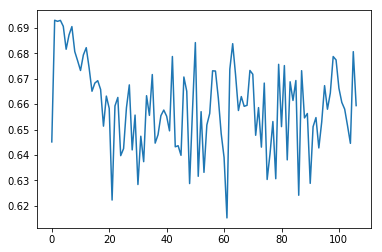

In [50]:
plt.plot(gen_loss)
plt.show()

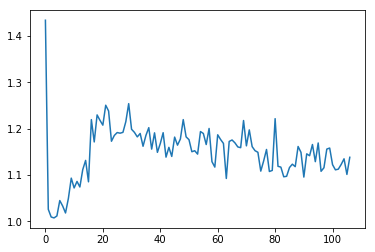

In [51]:
plt.plot(dis_loss)
plt.show()